In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display

In [ ]:
base_image_path = tf.keras.utils.get_file("Osc3728.jpeg", "https://i.imgur.com/Osc3728.jpeg")
style_image_path = tf.keras.utils.get_file("588BK.jpeg", "https://i.imgur.com/588BK.jpeg")
result_prefix = "generated"

655360/640463 [==============================] - 1s 1us/step


In [ ]:
total_variation_wt = 1e-6
style_wt = 1e-6
content_wt = 2.5e-8

In [ ]:
width, height = tf.keras.preprocessing.image.load_img(base_image_path).size
rows = 400
cols = int(width*rows/height)

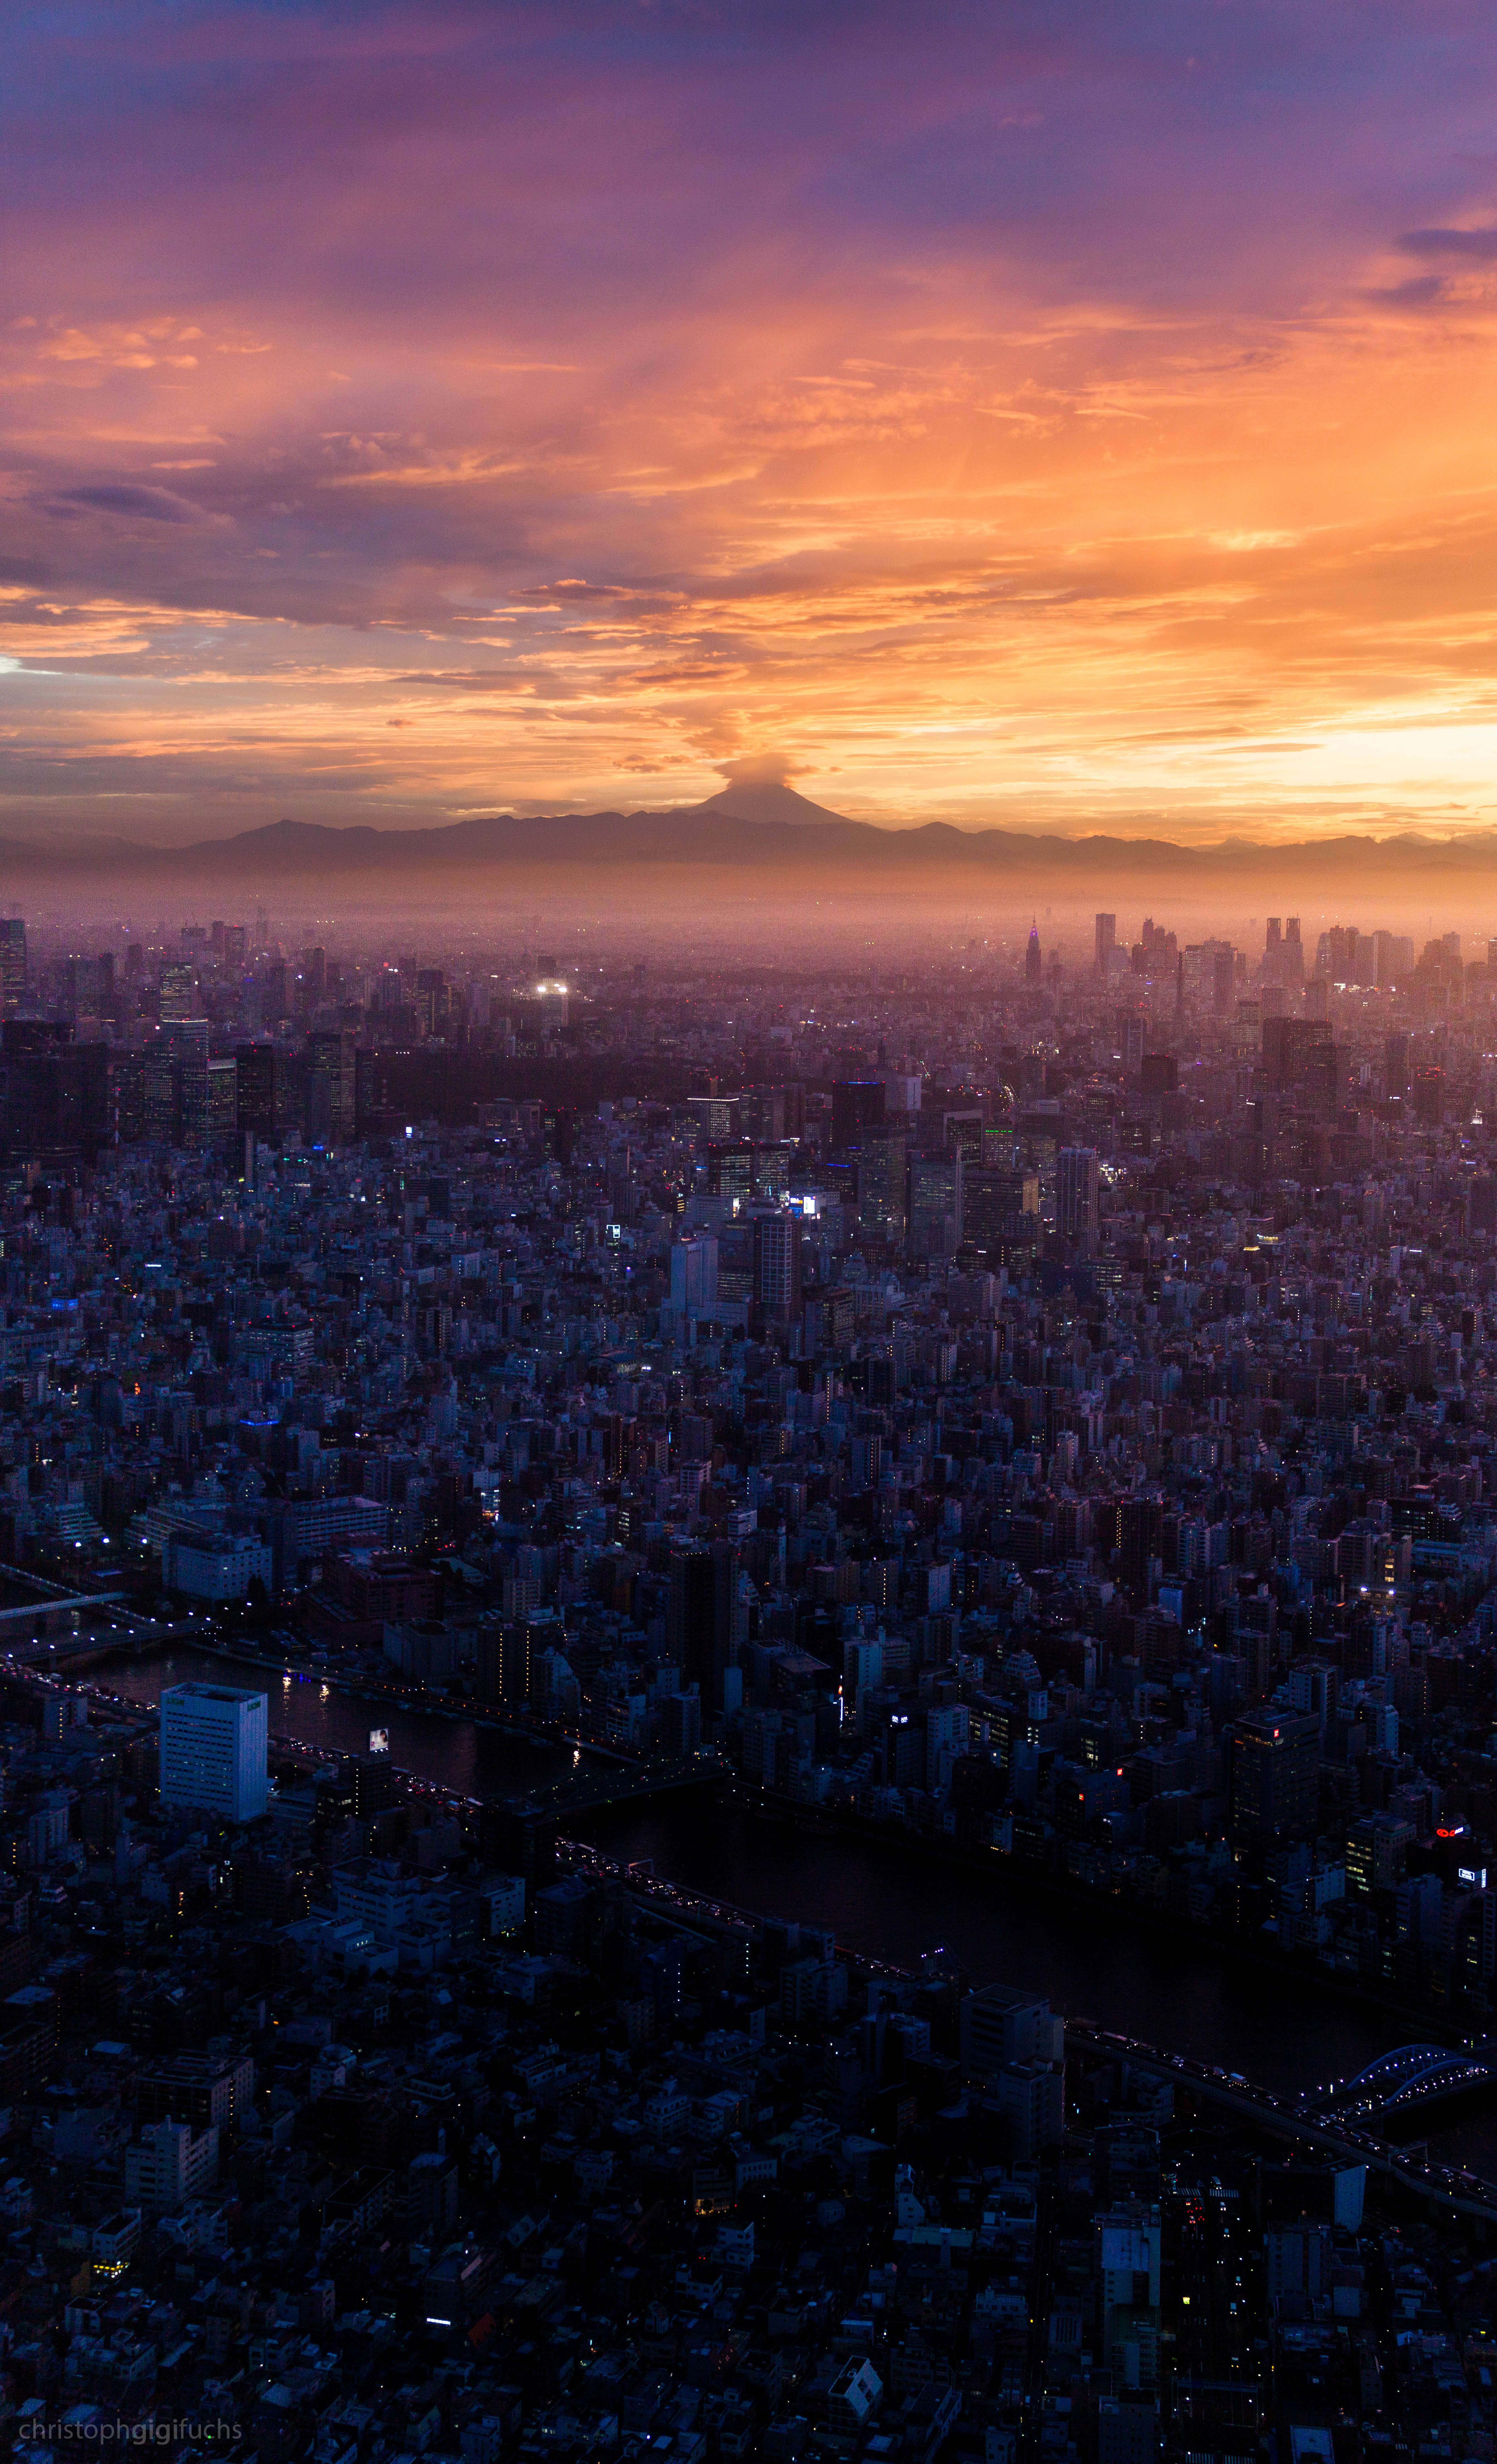

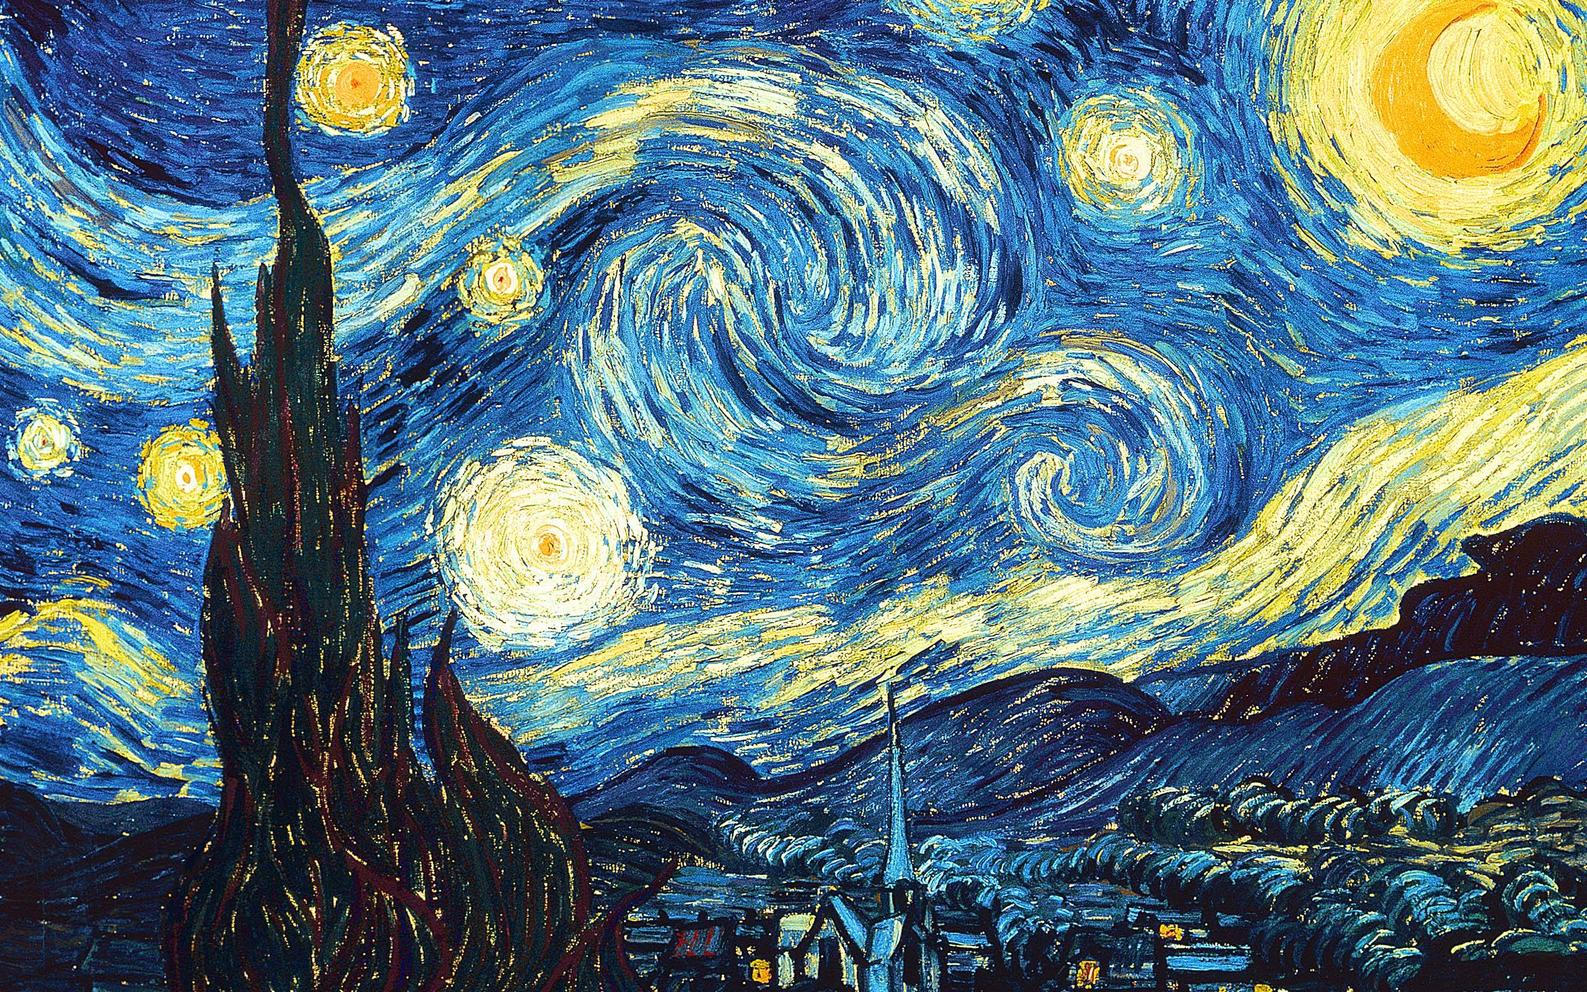

In [ ]:
display(Image(base_image_path))
display(Image(style_image_path))

In [ ]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(rows,cols))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
def deprocess_image(x):
    x = x.reshape((rows,cols,3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x,0,255).astype("uint8")
    return x

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x,(2, 0, 1))
    features = tf.reshape(x,(tf.shape(x)[0],-1))
    gram = tf.matmul(features,tf.transpose(features))
    return gram

In [ ]:
def style_loss(style,combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = rows*cols
    return tf.reduce_sum(tf.square(S-C))/(4.0*(channels**2)*(size**2))

In [ ]:
def content_loss(base,combination):
    return tf.reduce_sum(tf.square(combination-base))

In [ ]:
def total_variation_loss(x):
    a = tf.square(x[:,:rows-1,:cols-1,:] - x[:,1:,:cols-1,:])
    b = tf.square(x[:,:rows-1,:cols-1,:] - x[:,:rows-1,1:,:])
    return tf.reduce_sum(tf.pow(a+b,1.25))

In [ ]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet",include_top=False)
outputs_dict = dict([(layer.name,layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs,outputs=outputs_dict)

In [ ]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

In [ ]:
content_layer_name = "block5_conv2"

def compute_loss(combination_image,base_image,style_image):
    input_tensor = tf.concat([base_image,style_image,combination_image],axis=0)
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_features = layer_features[2,:,:,:]
    loss = loss + content_wt*content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1,:,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss(style_features, combination_features)
        loss += (style_wt/len(style_layer_names))*sl

    loss += total_variation_wt*total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image,base_image,style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image,base_image,style_image)
    grads = tape.gradient(loss,combination_image)
    return loss,grads

In [ ]:
optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0,decay_steps=100,decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 500
for i in range(1,iterations+1):
    loss, grads = compute_loss_and_grads(combination_image,base_image,style_image)
    optimizer.apply_gradients([(grads,combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" %(i,loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" %i
        tf.keras.preprocessing.image.save_img(fname,img)

Iteration 100: loss=8767.76
Iteration 200: loss=7773.87
Iteration 300: loss=6706.51
Iteration 400: loss=6418.99
Iteration 500: loss=5759.17


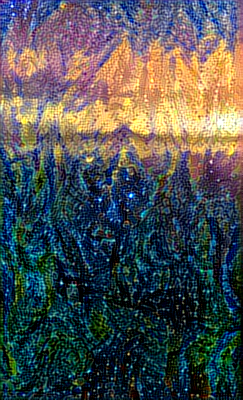

In [ ]:
display(Image(result_prefix + "_at_iteration_{}.png".format(iterations)))